In [1]:
import numpy as np
import os
import torch
import os
import struct
import matplotlib.pyplot as plt
from collections import OrderedDict
import time

## 数据加载类定义

In [4]:
class MNIST:
    def __init__(self, path, is_train=True, normalize=True, split=0.0):
        self.path = path
        self.is_train = is_train
        self.split = split
        self.images, self.labels = self._load_mnist()
        self.labels = self._one_hot(self.labels)
        if normalize:
            self.images = self.images / 255
        self.train_idx, self.valid_idx = self._split_validation(self.split)

    def _load_mnist(self):
        prefix_str = "train" if self.is_train else "t10k"
        labels_path = os.path.join(self.path, f'{prefix_str}-labels-idx1-ubyte')
        images_path = os.path.join(self.path, f'{prefix_str}-images-idx3-ubyte')
        with open(labels_path, 'rb') as lbpath:
            magic, n = struct.unpack('>II', lbpath.read(8))
            labels = np.fromfile(lbpath, dtype=np.uint8)
        with open(images_path, 'rb') as imgpath:
            magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
            images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        
        return images, labels

    def _split_validation(self, split):
        if split == 0.0:
            return None, None
        data_len = len(self.images)
        idx_full = np.arange(data_len)
        np.random.seed(0)
        np.random.shuffle(idx_full)
        len_valid = int(data_len * split)
        valid_idx = idx_full[0:len_valid]
        train_idx = idx_full[len_valid:]

        return train_idx, valid_idx
    
    def _one_hot(self, label):
        one_hot_label = np.zeros((len(self.labels), 10))
        idx_1 = np.arange(len(self.labels))
        idx_2 = self.labels.flatten()
        one_hot_label[idx_1, idx_2] = 1
        
        return one_hot_label

    def get_data_set(self):
        if self.train_idx is not None:
            return self.images[self.train_idx], self.labels[self.train_idx], self.images[self.valid_idx], self.labels[self.valid_idx]
        return self.images, self.labels, None, None

## ReLu激活函数类定义

In [5]:
class ReLu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

## 线性层类定义

In [6]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx

## Softmax和交叉熵损失函数类定义

In [ ]:
def softmax(a):
    c = np.max(a, axis=1, keepdims=True)
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a, axis=1, keepdims=True)
    y = exp_a / sum_exp_a

    return y

def cross_entropy(y, t):
    delta = 1e-7
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + delta)) / batch_size

In [7]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy(self.y, self.t)

        return self.loss

    def backward(self, d_out=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size

        return dx

## 多层感知机类定义

In [8]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['ReLu1'] = ReLu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, y, t):
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(y.shape[0])
        return accuracy
    
    def train(self, x, t):
        # forward
        y = self.predict(x)
        loss = self.lastLayer.forward(y, t)

        # backward
        d_out = 1
        d_out = self.lastLayer.backward(d_out)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            d_out = layer.backward(d_out)

        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads, loss
    
    def test(self, x, t):
        # forward
        y = self.predict(x)
        loss = self.lastLayer.forward(y, t)
        accuracy = self.accuracy(y, t)

        return loss, accuracy

## SGD、Momentum和AdaGrad优化算法类定义

In [9]:
class SGD:
    def __init__(self, lr=0.1):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [10]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

In [11]:
class AdaGrad:
    def __init__(self, lr=0.1):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

## 初始化训练设置

In [12]:
path = "../minist/data/MNIST/raw/"
x_train, t_tarin, x_valid, t_valid = MNIST(path, is_train=True, split=0.1).get_data_set()
x_test, t_test, _, _ = MNIST(path, is_train=False).get_data_set()
iters_num = 20000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
# optimizer = SGD(lr=learning_rate)
iter_per_epoch = max(train_size / batch_size, 1)

## 训练

In [13]:
loss_list = [[], [], []]
train_acc_list = [[], [], []]
test_acc_list = [[], [], []]
train_loss_list = [[], [], []]
test_loss_list = [[], [], []]
time_log = [[], [], []]
optimizers = [SGD(lr=learning_rate), Momentum(lr=learning_rate), AdaGrad(lr=learning_rate)]
for n, optimizer in enumerate(optimizers):
    network = MLP(input_size=784, hidden_size=50, output_size=10)
    for i in range(iters_num):
        start = time.time()
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_tarin[batch_mask]

        # 前向计算、反向传播
        grad, loss = network.train(x_batch, t_batch)
        loss_list[n].append(loss)
        # 参数更新
        optimizer.update(network.params, grad)

        if i % iter_per_epoch == 0:
            train_loss, train_accuracy = network.test(x_train, t_tarin)
            test_loss, test_accuracy = network.test(x_valid, t_valid)
            train_acc_list[n].append(train_accuracy)
            test_acc_list[n].append(test_accuracy)
            train_loss_list[n].append(train_loss)
            test_loss_list[n].append(test_loss)
            # print(train_accuracy, test_accuracy)
        end = time.time()
        time_log[n].append(end - start)
    print(network.test(x_test, t_test))

(0.09355131496605096, 0.9734)
(0.14759311948856463, 0.9756)
(0.13289538628677777, 0.9656)


## 统计每一步的训练时间

In [15]:
sum(time_log[0]) / len(time_log[0])

0.0021488922238349912

## 训练结果可视化

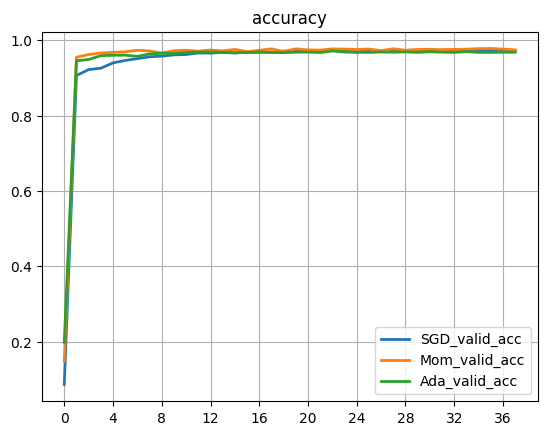

In [25]:
plt.figure()
x = range(0, len(train_acc_list[0]))
# plt.plot(x, train_acc_list[0], label='SGD_train_acc', linewidth=2)
plt.plot(x, test_acc_list[0], label='SGD_valid_acc', linewidth=2)
# plt.plot(x, train_acc_list[1], label='Mom_train_acc', linewidth=2)
plt.plot(x, test_acc_list[1], label='Mom_valid_acc', linewidth=2)
# plt.plot(x, train_acc_list[2], label='Ada_train_acc', linewidth=2)
plt.plot(x, test_acc_list[2], label='Ada_valid_acc', linewidth=2)
plt.xticks(range(0, len(train_loss_list[0]), 4))
plt.legend()
plt.grid()
plt.title("accuracy")
# plt.savefig('./outputs/loss.png')
plt.show()

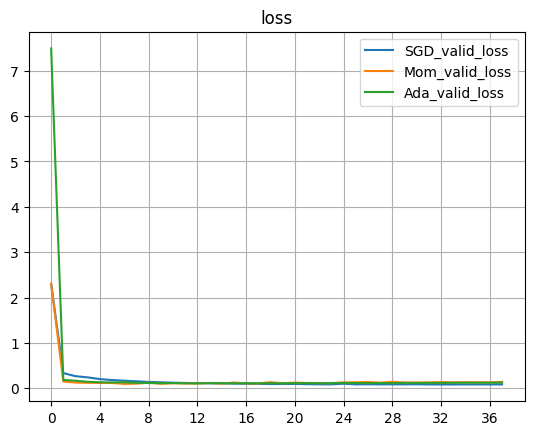

In [26]:
plt.figure()
# losses_d = [x.item() for x in train_acc_list]
# losses_g = [x.item() for x in test_acc_list]
x = range(len(train_loss_list[0]))
# plt.plot(x, train_loss_list[0], label='SGD_train_loss')
plt.plot(x, test_loss_list[0], label='SGD_valid_loss')
# plt.plot(x, train_loss_list[1], label='Mom_train_loss')
plt.plot(x, test_loss_list[1], label='Mom_valid_loss')
# plt.plot(x, train_loss_list[2], label='Ada_train_loss')
plt.plot(x, test_loss_list[2], label='Ada_valid_loss')
plt.xticks(range(0, len(train_loss_list[0]) - 1, 4))
plt.legend()
plt.title("loss")
plt.grid()
# plt.savefig('./outputs/loss.png')
plt.show()